Load data from file assignment_data.jsonl.bz2

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, TimestampType
appName = "Player Session Insights"
master = "local"

# Create Spark session
spark = SparkSession.builder \
    .appName(appName) \
    .master(master) \
    .getOrCreate()

# Create a schema for the dataframe
schema = StructType([
    StructField('country', StringType(), True),
    StructField('event', StringType(), True),
    StructField('player_id', StringType(), True),
    StructField('session_id', StringType(), True),
    StructField('ts', TimestampType(), True)
])

# Create data frame
json_file_path = 'data/assignment_data.jsonl.bz2'
df = spark.read.json(json_file_path, schema)
df.show()

+-------+-----+--------------------+--------------------+-------------------+
|country|event|           player_id|          session_id|                 ts|
+-------+-----+--------------------+--------------------+-------------------+
|     PK|start|d6313e1fb7d247a6a...|674606b1-2270-428...|2016-11-22 20:40:50|
|   null|  end|20ac16ebb30a47708...|16ca9d01-d240-452...|2016-11-18 06:24:50|
|   null|  end|318e22b061b54042b...|5f933591-8cd5-414...|2016-11-16 18:01:37|
|   null|  end|29bb390d9b1b4b4b9...|ef939180-692a-484...|2016-11-13 10:38:09|
|     GH|start|a477ecabc3cc455cb...|4c55263e-66b2-481...|2016-11-29 19:31:43|
|     SK|start|1ec36a67785046b3b...|3346a60a-0989-404...|2016-11-16 05:36:16|
|     DE|start|9595af0063e94cb8a...|06830030-d091-428...|2016-11-07 01:18:09|
|   null|  end|8d0e3cd4a25d4a089...|a78a4889-4bcf-45a...|2016-11-24 02:12:33|
|   null|  end|e59f1fa31e144fd8b...|dd223ea6-0e6b-4dd...|2016-11-13 00:35:30|
|   null|  end|fd8a1e9fff25471da...|3015bf71-4b28-4c9...|2016-11

How many sessions are in the dataset:

In [2]:
df.registerTempTable('insights')
number_sessions_query = "select count(distinct session_id) as number_of_sessions from insights"
number_sessions = spark.sql(number_sessions_query)
number_sessions.show()

+------------------+
|number_of_sessions|
+------------------+
|            500587|
+------------------+



How many sessions are completed per country?


In [3]:
session_per_country_query = """select t1.country, count(t1.session_id) as number_of_sessions from insights t1 
                            inner join insights t2 on t1.session_id=t2.session_id and t1.event!=t2.event 
                            where t1.country!=""  group by t1.country"""
session_per_country = spark.sql(session_per_country_query)
session_per_country.show()

+-------+------------------+
|country|number_of_sessions|
+-------+------------------+
|     DZ|              1953|
|     MM|              1996|
|     LT|              2276|
|     TC|              2206|
|     SC|              1774|
|     AZ|              2670|
|     FI|              2349|
|     PM|              2112|
|     UA|              2141|
|     RO|              2550|
|     KI|              1662|
|     ZM|              1680|
|     SL|              2202|
|     LA|              2402|
|     NL|              2247|
|     SB|              1626|
|     BS|              2239|
|     BW|              2168|
|     MN|              2365|
|     PL|              2119|
+-------+------------------+
only showing top 20 rows



How many sessions per player:

In [4]:
session_per_player_query = """select player_id, count(session_id) as number_of_sessions from insights 
                            where event = "end"
                            group by player_id"""
session_per_player = spark.sql(session_per_player_query)
session_per_player.show()

+--------------------+------------------+
|           player_id|number_of_sessions|
+--------------------+------------------+
|05e73a69c41943498...|                25|
|465f81dfdee345669...|                33|
|522a28a053a44af69...|                46|
|3f282f08b347481b8...|                37|
|cd5742d5ad5247a79...|                 3|
|3e888630d54e4dde9...|                42|
|3aa78890e9454b46b...|                20|
|fffa44da04a24d799...|                27|
|f147eebba02a4da3b...|                42|
|37370d0139544d1ca...|                50|
|e8f36a8efded42bfb...|                50|
|293da457fd584ea18...|                34|
|3cc80842b10c477d8...|                43|
|0395b10232f34d3eb...|                49|
|600894a22d3a4aa68...|                36|
|2325e83bc1d14c4fb...|                38|
|ec0a0483fddd4ebfa...|                49|
|154470fc7c23483c8...|                37|
|a677d0d5099d40008...|                46|
|5f96555b2e074e7aa...|                12|
+--------------------+------------

What is the country with more sessions started during 2018:

In [46]:
from pyspark.sql.functions import year
country_sessions_2018_query= """select country, count(session_id) as number_of_sessions from insights 
                            where year(ts) = "2018" and event = "start"
                            group by country"""
country_sessions_2018 = spark.sql(country_sessions_2018_query)
country_sessions_2018.show()

+-------+------------------+
|country|number_of_sessions|
+-------+------------------+
+-------+------------------+



Plot the player sessions completed per country
NOTE 1: I understood from this questions that 
you want a digram with number of sessions per country found in the question
How many sessions are completed per country?
NOTE 2: For stylistic purpose I limit the number of sessions per country to 20.
To get all the results we should remove the limit



<AxesSubplot:xlabel='country'>

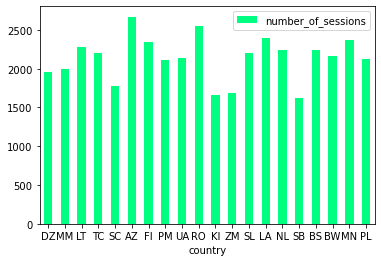

In [5]:
import matplotlib.pyplot as plt
pdf1=session_per_country.limit(20).toPandas()
pdf1.plot(kind='bar',x='country',y='number_of_sessions',colormap='winter_r', rot=0)